# Q-3 MNIST Classification


*   Akshay Bankar (2019201011)


## Classificaton using linear SVM


Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted a

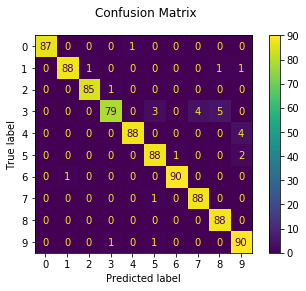

In [0]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

classifier = svm.SVC(gamma=0.001)

X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)


### Read binary file of the dataset

In [0]:
import time
stime = time.time()

import struct as st
import numpy as np
filename = {'images' : 'dataset/train-images-idx3-ubyte' ,'labels' : 'dataset/train-labels-idx1-ubyte'}

labels_array = np.array([])

data_types = {
        0x08: ('ubyte', 'B', 1),
        0x09: ('byte', 'b', 1),
        0x0B: ('>i2', 'h', 2),
        0x0C: ('>i4', 'i', 4),
        0x0D: ('>f4', 'f', 4),
        0x0E: ('>f8', 'd', 8)}

for name in filename.keys():
    if name == 'images':
        imagesfile = open(filename[name],'rb')
    if name == 'labels':
        labelsfile = open(filename[name],'rb')

imagesfile.seek(0)
magic = st.unpack('>4B',imagesfile.read(4))
if(magic[0] and magic[1])or(magic[2] not in data_types):
    raise ValueError("File Format not correct")

nDim = magic[3]
print ("Data is ",nDim,"-D")

#offset = 0004 for number of images
#offset = 0008 for number of rows
#offset = 0012 for number of columns
#32-bit integer (32 bits = 4 bytes)
imagesfile.seek(4)
nImg = st.unpack('>I',imagesfile.read(4))[0] #num of images/labels
nR = st.unpack('>I',imagesfile.read(4))[0] #num of rows
nC = st.unpack('>I',imagesfile.read(4))[0] #num of columns
nBytes = nImg*nR*nC
labelsfile.seek(8) #Since no. of items = no. of images and is already read
print ("no. of images :: ",nImg)
print ("no. of rows :: ",nR)
print ("no. of columns :: ",nC)

#Read all data bytes at once and then reshape
images_array = 255 - np.asarray(st.unpack('>'+'B'*nBytes,imagesfile.read(nBytes))).reshape((nImg,nR,nC))
labels_array = np.asarray(st.unpack('>'+'B'*nImg,labelsfile.read(nImg))).reshape((nImg,1))

print (labels_array)
print (labels_array.shape)
print (images_array.shape)

Data is  3 -D
no. of images ::  60000
no. of rows ::  28
no. of columns ::  28
[[5]
 [0]
 [4]
 ...
 [5]
 [6]
 [8]]
(60000, 1)
(60000, 28, 28)


### Read data using MNIST library 

In [2]:
from mnist import MNIST
import numpy as np
mndata = MNIST('./dataset')
images_array, labels_array = mndata.load_training()
print(np.shape(images_array))

(60000, 784)


## Classification using CNN

> Import Pytorch libraries



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


> Define class for CNN



In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



> Define parameters for training



In [24]:
n_epochs = 8
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 1000



> Initialize network



In [14]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)



> Prepare train and test data



In [15]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
X_train, X_test, y_train, y_test = train_test_split(np.asarray(images_array), np.asarray(labels_array), test_size=0.20)


###############
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
input_shape = (28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print('Number of images in x_train', X_train.shape[0])
print('Number of images in x_test', X_test.shape[0])
##############


torch_X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

torch_X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)


train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)


train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


x_train shape: (48000, 1, 28, 28)
Number of images in x_train 48000
Number of images in x_test 12000


In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(images_array) for i in range(n_epochs + 1)]

In [17]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [22]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      #print(data.shape)
      #print(np.shape(target))
      #print(data)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [25]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/48000 (0%)]	Loss: 0.712653
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.404447

Test set: Avg. loss: 0.1710, Accuracy: 11416/12000 (95%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.818281
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.493597

Test set: Avg. loss: 0.1632, Accuracy: 11432/12000 (95%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.682777
Train Epoch: 3 [32000/48000 (67%)]	Loss: 0.365860

Test set: Avg. loss: 0.1592, Accuracy: 11438/12000 (95%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 1.049464
Train Epoch: 4 [32000/48000 (67%)]	Loss: 0.418026

Test set: Avg. loss: 0.1582, Accuracy: 11428/12000 (95%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 0.775062
Train Epoch: 5 [32000/48000 (67%)]	Loss: 0.609121

Test set: Avg. loss: 0.1514, Accuracy: 11471/12000 (96%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 0.769052
Train Epoch: 6 [32000/48000 (67%)]	Loss: 0.510075

Test set: Avg. loss: 0.1495, Accuracy: 11476/12000 (96%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 0.743701
Train Epoch: 7 [32000/48000 (67